In [1]:
import sys 
sys.path.append('../')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pysr import PySRRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from gplearn.genetic import SymbolicRegressor
from sympy import *

In [3]:
%load_ext autoreload
%autoreload 2
from relation import Distribution
from relation import Analysis

In [4]:
a = Analysis([62.5,15],'022','b')

: 

: 

In [ ]:
df = a.get_dataframe()

In [ ]:
df

,x,y,z,Veff,num_clusters,cluster_number_density,num_galaxies,galaxy_number_density,Mstar,Mgas,Vlos,Y,M
0,331668.485714,632168.971429,645139.057143,366.954756,22,1.750452,165,4.090890,7.885119e+12,3.208288e+13,88.2910,-14.057839,33.223239
1,255348.571429,616694.328571,618932.728571,502.538950,17,1.352622,272,6.743770,1.274270e+13,5.239015e+13,192.5920,-12.787507,33.653749
2,78788.437143,650603.300000,908410.714286,178.124915,12,0.954792,491,12.173497,1.151310e+13,4.106893e+13,37.6421,-14.663424,33.415400
3,780125.985714,453116.557143,461240.671429,431.962604,20,1.591320,374,9.272684,2.092359e+13,8.021837e+13,223.4660,-12.212787,34.109509
4,653411.428571,314633.085714,399264.285714,358.730607,19,1.511754,543,13.462747,1.667361e+13,6.193907e+13,234.9400,-12.421318,33.861694
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42023,432932.857143,702466.157143,272588.400000,401.707695,6,0.477396,67,1.661149,4.676435e+11,3.808745e+11,284.8770,-17.320027,29.984700
42024,852456.514286,721343.128571,742103.571429,603.670443,17,1.352622,57,1.413217,3.968064e+11,7.499590e+11,594.0110,-15.907638,30.005611
42025,610825.271429,669634.242857,114618.024286,507.285362,40,3.182640,90,2.231395,4.252189e+11,7.034627e+11,156.6090,-17.304787,30.054766
42026,381813.028571,306233.614286,668153.342857,336.366795,9,0.716094,49,1.214870,4.894473e+11,4.714246e+11,151.6930,-17.736937,29.951394


In [18]:
ng = df['num_galaxies']

In [19]:
dg = (ng - np.mean(ng))/np.mean(ng)

In [21]:
k = np.fft.fftfreq(len(dg))

In [23]:
dg_k = np.fft.fft(dg)

In [33]:
inte = -1j * k * dg_k /(2*np.power(k, 2))

/tmp/ipykernel_3156266/3824552216.py:1: RuntimeWarning: invalid value encountered in true_divide
  inte = -1j * k * dg_k /(2*np.power(k, 2))


In [34]:
inte[k==0] = 0

In [35]:
s = np.fft.ifft(inte)

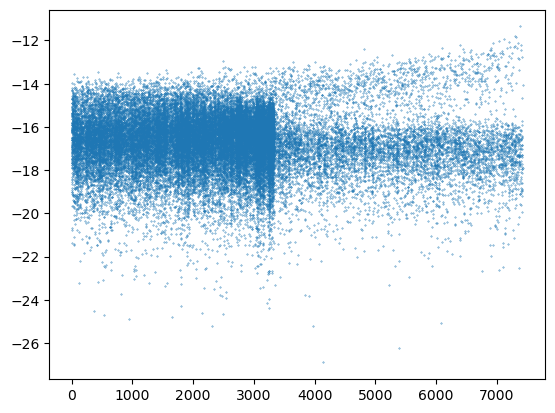

In [36]:
plt.scatter(np.abs(s),df['Y'],s=0.1)

In [6]:
train_df, test_df = train_test_split(df, train_size=0.3, random_state=42)

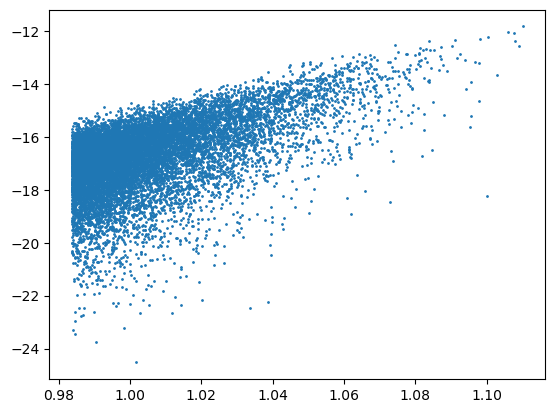

In [7]:
plt.scatter(train_df['M']/np.median(train_df['M']),train_df['Y'],s=1)

In [8]:
def get_inp(features):
    xlen = len(features[0])
    ylen = len(features)
    inp = np.zeros((xlen,ylen))
    for i in range(len(features)):
        inp[:,i] = features[i]
    return inp

In [9]:
inp1 = get_inp([train_df['M']])
inp2 = get_inp([train_df['M'],np.log(train_df['Mstar'])])
inp3 = get_inp([train_df['M'],np.log(train_df['Mstar']),train_df['galaxy_number_density']])

In [11]:
Y = train_df['Y']

In [12]:
regr = RandomForestRegressor(max_depth=50, random_state=0,n_estimators=50,n_jobs=-1)
regr.fit(inp1, Y)

RandomForestRegressor(max_depth=50, n_estimators=50, n_jobs=-1, random_state=0)

In [12]:
Y_prime = Y/regr.predict(inp1)

In [13]:
regr2 = RandomForestRegressor(max_depth=50, random_state=0,n_estimators=50,n_jobs=-1)
regr2.fit(inp2, Y)

RandomForestRegressor(max_depth=50, n_estimators=50, n_jobs=-1, random_state=0)

In [14]:
regr3 = RandomForestRegressor(max_depth=50, random_state=0,n_estimators=50,n_jobs=-1)
regr3.fit(inp3, Y)

RandomForestRegressor(max_depth=50, n_estimators=50, n_jobs=-1, random_state=0)

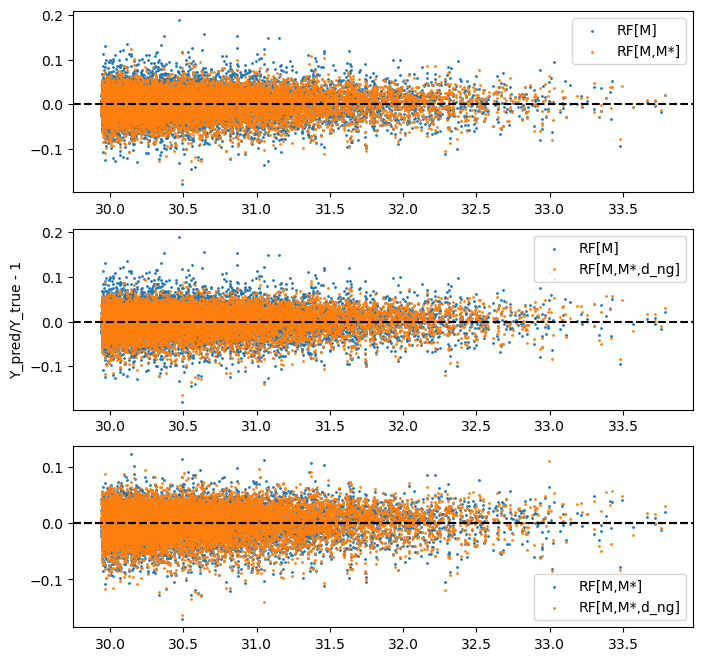

In [15]:
plt.figure(figsize=(8,8))
plt.subplot(3,1,1)
plt.scatter(train_df['M'],regr.predict(inp1)/Y -1,s=1,label='RF[M]')
plt.scatter(train_df['M'],regr2.predict(inp2)/Y -1,s=1,label='RF[M,M*]')
plt.axhline(0,c='k',ls='--')
plt.legend()
plt.subplot(3,1,2)
plt.scatter(train_df['M'],regr.predict(inp1)/Y -1,s=1,label='RF[M]')
plt.scatter(train_df['M'],regr3.predict(inp3)/Y -1,s=1,label='RF[M,M*,d_ng]')
plt.legend()
plt.ylabel('Y_pred/Y_true - 1')
plt.axhline(0,c='k',ls='--')
plt.subplot(3,1,3)
plt.axhline(0,c='k',ls='--')
plt.scatter(train_df['M'],regr2.predict(inp2)/Y -1,s=1,label='RF[M,M*]')
plt.scatter(train_df['M'],regr3.predict(inp3)/Y -1,s=1,label='RF[M,M*,d_ng]')
plt.legend()
plt.axhline(0,c='k',ls='--')


In [116]:
inp_1 = get_inp([train_df['M']*1.2])
inp_2 = get_inp([np.log(train_df['Mstar'])])
inp_3 = get_inp([np.log(train_df['Mstar']),train_df['galaxy_number_density']])
inp_4 = get_inp([train_df['galaxy_number_density']])

In [117]:
model = PySRRegressor(
    niterations=20,
    maxsize=10,
    maxdepth=10,
    binary_operators=["+", "-", "*", "/",'pow',],
    unary_operators=["neg","exp","log","sqrt",],
    procs=4,
    model_selection="best",)
model.fit(inp_1,Y,weights=train_df['M']**.5)

/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/pysr/sr.py:1257: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!

Cycles per second: 4.050e+04
Head worker occupation: 4.6%
Progress: 112 / 300 total iterations (37.333%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           1.989e+00  1.738e-06  -16.73482
3           1.328e+00  2.019e-01  (x0 - 53.485783)
5           1.321e+00  2.661e-03  ((x0 * 1.1150154) - 57.7127)

Press 'q' and then <enter> to stop execution early.

Cycles per second: 4.070e+04
Head worker occupation: 3.3%
Progress: 225 / 300 total iterations (75.000%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           1.989e+00  1.738e-06  -16.73482
3           1.328e+00  2.019e-01  (x0 + -53.485886)
5           1.321e+00  2.660e-03  ((x0 * 1.1150154) - 57.7127)

Press 'q' and then <enter> to stop execution early.


PySRRegressor.equations_ = [
	   pick     score                      equation      loss  complexity
	0        0.000000                     -16.73482  1.988689           1
	1  >>>>  0.201903             (x0 + -53.485886)  1.327994           3
	2        0.002660  ((x0 * 1.1150154) - 57.7127)  1.320946           5
]

In [118]:
Y_primes = Y/train_df['M']*1.2

In [119]:
model1 = PySRRegressor(
    niterations=20,
    maxsize=10,
    maxdepth=10,
    binary_operators=["+", "-", "*", "/",'pow',],
    unary_operators=["neg","exp","log","sqrt",],
    procs=4,
    model_selection="best",)
model1.fit(inp_2,Y_primes,weights=train_df['M']**.5)

/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/pysr/sr.py:1257: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!

Cycles per second: 3.810e+04
Head worker occupation: 1.8%
Progress: 105 / 300 total iterations (35.000%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           3.971e-03  8.207e-07  -0.6566003
3           3.069e-03  1.288e-01  (-18.0227 / x0)
5           2.283e-03  1.479e-01  ((-56.720783 / x0) + 1.4115885)

Press 'q' and then <enter> to stop execution early.

Cycles per second: 3.720e+04
Head worker occupation: 1.9%
Progress: 206 / 300 total iterations (68.667%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           3.971e-03  8.207e-07  -0.6566003
3           3.069e-03  1.288e-01  (-18.022705 / x0)
5           2.283e-03  1.479e-01  ((-56.720783 / x0) + 1.4115885)
6           2.281e-03  8.535e-04  ((-22.576365 / log(x0)) + 6.160871)

Press 'q' and then <enter> to stop execution early.


PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                         -0.6566003   
	1        0.128842                                  (-18.022434 / x0)   
	2  >>>>  0.147903                    ((-56.720783 / x0) + 1.4115885)   
	3        0.003613            ((neg(x0) * -0.073673055) + -2.6784375)   
	4        0.000058  ((neg(x0 + 0.0067914985) * -0.073673055) + -2....   
	
	       loss  complexity  
	0  0.003971           1  
	1  0.003069           3  
	2  0.002283           5  
	3  0.002275           6  
	4  0.002275           8  
]

In [120]:
model2 = PySRRegressor(
    niterations=20,
    maxsize=10,
    maxdepth=10,
    binary_operators=["+", "-", "*", "/",'pow',],
    unary_operators=["neg","exp","log","sqrt",],
    procs=4,
    model_selection="best",)
model2.fit(inp_4,Y_primes,weights=train_df['M']**.5)

/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/pysr/sr.py:1257: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!

Cycles per second: 3.600e+04
Head worker occupation: 2.1%
Progress: 101 / 300 total iterations (33.667%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           3.971e-03  8.207e-07  -0.6566003
5           3.518e-03  3.031e-02  ((0.97795814 ^ x0) * -0.69947654)
6           3.518e-03  1.025e-05  (sqrt(0.95676637 ^ x0) * -0.6991501)
8           3.518e-03  8.936e-08  (sqrt(0.95676637 ^ exp(log(x0))) * -0.6991501)
9           3.517e-03  2.922e-04  ((0.97795814 ^ (x0 - (0.114685036 ^ x0))) * -0.69947654)

Press 'q' and then <enter> to stop execution early.

Cycles per second: 3.440e+04
Head worker occupation: 1.8%
Progress: 192 / 300 total iterations (64.000%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           3.971e-03  8.207e-07  -0.6566003
5           3.518e-03  3.031e-02  (-0.69944775 * (0.97796756 ^ x0))
6           3.518e-03  9.716e-06  ((sqrt(0.95676637) ^ x0) * 

PySRRegressor.equations_ = [
	   pick         score                                           equation  \
	0        0.000000e+00                                         -0.6566003   
	1  >>>>  3.030701e-02                  (-0.69944775 * (0.97796756 ^ x0))   
	2        9.749959e-06             ((sqrt(0.95676637) ^ x0) * -0.6991501)   
	3        1.137027e-07       (((0.907292 ^ x0) ^ 0.2274453) * -0.6991498)   
	4        1.461009e-04  ((0.97795814 ^ (x0 - (0.114685036 ^ x0))) * -0...   
	5        4.436970e-04  ((0.97795814 ^ log(exp(x0) + log(x0))) * -0.69...   
	
	       loss  complexity  
	0  0.003971           1  
	1  0.003518           5  
	2  0.003518           6  
	3  0.003518           7  
	4  0.003517           9  
	5  0.003515          10  
]

In [121]:
model3 = PySRRegressor(
    niterations=20,
    maxsize=10,
    maxdepth=10,
    binary_operators=["+", "-", "*", "/",'pow',],
    unary_operators=["neg","exp","log","sqrt",],
    procs=4,
    model_selection="best",)
model3.fit(inp_3,Y_primes,weights=train_df['M']**.5)

/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/pysr/sr.py:1257: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Started!

Cycles per second: 3.720e+04
Head worker occupation: 2.6%
Progress: 103 / 300 total iterations (34.333%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           3.971e-03  8.207e-07  -0.6566003
3           3.069e-03  1.288e-01  (-18.022705 / x0)
5           2.283e-03  1.479e-01  ((-56.734055 / x0) + 1.4120746)
6           2.281e-03  8.552e-04  ((-22.573648 / log(x0)) - -6.1600475)

Press 'q' and then <enter> to stop execution early.

Cycles per second: 4.260e+04
Head worker occupation: 2.5%
Progress: 236 / 300 total iterations (78.667%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           3.971e-03  8.207e-07  -0.6566003
3           3.069e-03  1.288e-01  (-18.022438 / x0)
5           2.283e-03  1.479e-01  ((-56.69006 / x0) + 1.4104681)
6           2.281e-03  8.551e-04  ((-22.588757 / log(x0)) + 6.1646194)
9           2.258e-03  3.385e-03  (((-56.727425 - (0.5097451 /

PySRRegressor.equations_ = [
	   pick     score                                           equation  \
	0        0.000000                                         -0.6566003   
	1        0.128842                                  (-18.022438 / x0)   
	2  >>>>  0.147902                     ((-56.69006 / x0) + 1.4104681)   
	3        0.000855               ((-22.588757 / log(x0)) + 6.1646194)   
	4        0.000107     ((-21.539791 / exp(log(sqrt(x0)))) + 3.456258)   
	5        0.009974  (((-56.695484 - (0.5096945 / x1)) / x0) + 1.41...   
	
	       loss  complexity  
	0  0.003971           1  
	1  0.003069           3  
	2  0.002283           5  
	3  0.002281           6  
	4  0.002281           8  
	5  0.002258           9  
]

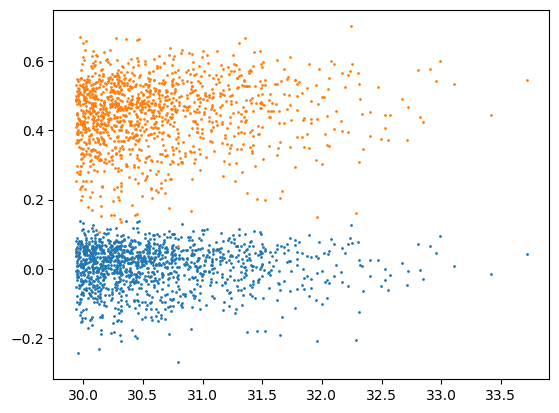

In [126]:
plt.scatter(train_df['M'],model.predict(inp1,2)/Y -1,s=1,label='PySR[M]')
#plt.scatter(train_df['M'],train_df['M']*1.2*model1.predict(inp2)/Y -1,s=1,label='PySR[M,M*]')
#plt.scatter(train_df['M'],train_df['M']*1.2*model2.predict(inp_4)/Y -1,s=1,label='PySR[M,d_ng]')
plt.scatter(train_df['M'],train_df['M']*1.2*model3.predict(inp_3)/Y -1,s=1,label='PySR[M,M*,d_ng]')